# E13.5 to PD4 integration

In [1]:
import scanpy as sc, numpy as np, pandas as pd
import scvi
scvi.settings.seed = 16

Global seed set to 0
Global seed set to 16


In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
from matplotlib.pyplot import rc_context
from matplotlib import pyplot as plt

## Load and prep data

In [4]:
adata = sc.read("E13-PD4.processed.concatenated.h5ad") #amb dbl filtered

Only considering the two last: ['.concatenated', '.h5ad'].
Only considering the two last: ['.concatenated', '.h5ad'].


In [5]:
#adata.var_names = adata.var["features"]
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

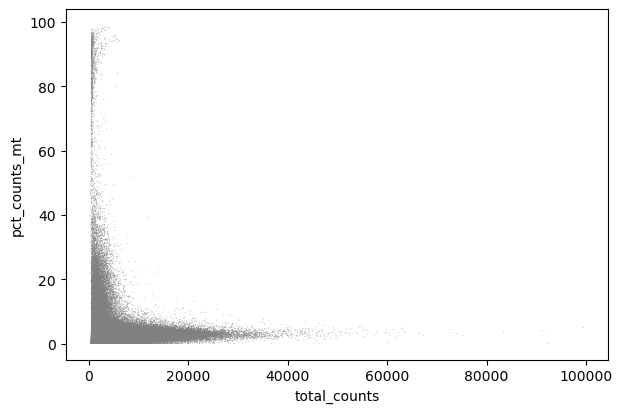

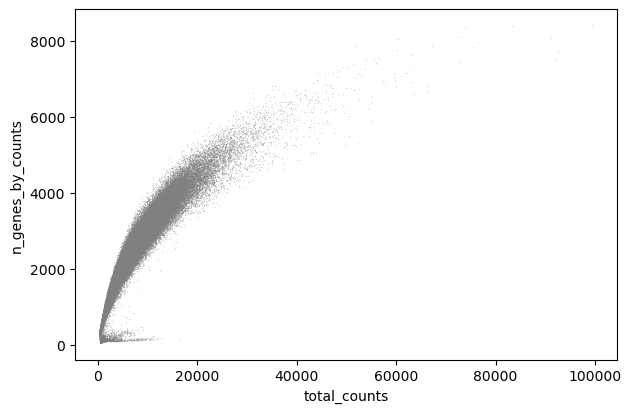

In [6]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', groups="batch")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
adata = adata[adata.obs.n_genes_by_counts > 1000, 0:]
adata = adata[adata.obs.pct_counts_mt < 7.5, :]

In [9]:
adata.layers["counts"] = adata.X.copy() # preserve counts for scVI = this is raw count

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata # freeze the state in `.raw`

/tmp/ipykernel_31715/2137464586.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.layers["counts"] = adata.X.copy() # preserve counts for scVI = this is raw count


In [10]:
adata

AnnData object with n_obs × n_vars = 85645 × 24558
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'bulk.ident', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'scDblFinder.selected-0', 'scDblFinder.selected-1', 'scDblFinder.selected-10', 'scDblFinder.selected-2', 'scDblFinder.selected-3', 'scDblFinder.selected-4', 'scDblFinder.selected-5', 'scDblFinder.selected-6', 'scDblFinder.selected-7', 'scDblFinder.selected-8', 'scDblFinder.selected-9', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5500,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch"
)

/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [12]:
adata

AnnData object with n_obs × n_vars = 85645 × 5500
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'bulk.ident', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'scDblFinder.selected-0', 'scDblFinder.selected-1', 'scDblFinder.selected-10', 'scDblFinder.selected-2', 'scDblFinder.selected-3', 'scDblFinder.selected-4', 'scDblFinder.selected-5', 'scDblFinder.selected-6', 'scDblFinder.selected-7', 'scDblFinder.selected-8', 'scDblFinder.selected-9', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'counts'

## scVI training

In [13]:
scvi.model.SCVI.setup_anndata(adata,
                              layer="counts", batch_key="batch",
                             continuous_covariate_keys=["pct_counts_mt"])                         
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb") #We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.
vae.train()

/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=93 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 93/93: 100%|██████████| 93/93 [20:41<00:00, 13.35s/it, loss=1.76e+03, v_num=1]


In [14]:
#vae.save("221208.E13-PD4.hvg5500.seed16.model")

In [15]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [16]:
adata.layers["scvi_normalized"] = vae.get_normalized_expression(
    library_size=10e4
)

In [17]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.4)

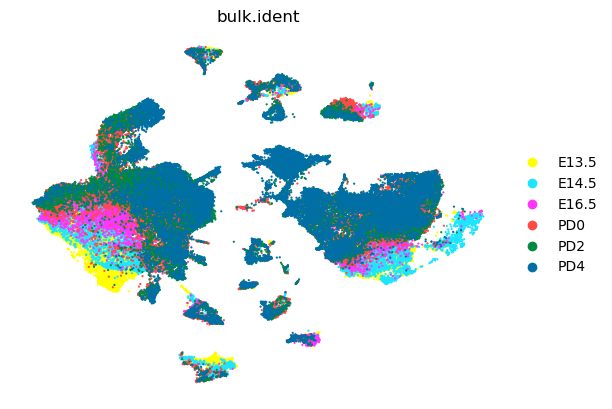

In [18]:
sc.pl.umap(
    adata,
    color=["bulk.ident"],
    frameon=False, palette=sc.pl.palettes.default_102, size=10
)

In [19]:
#adata = sc.read_h5ad("221212.adata.e13_pd4.scviintegrated.hvg5500.seed16.gene1000.mt7.5.h5ad")

## Clustering

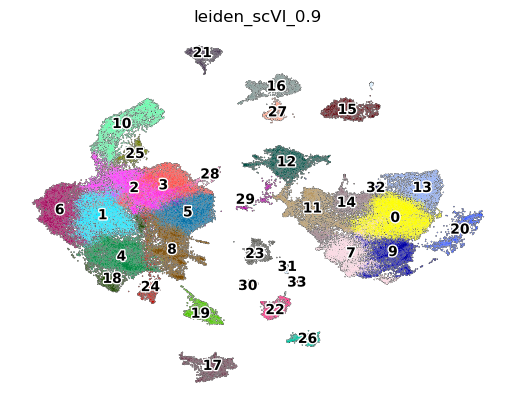

In [20]:
sc.tl.leiden(adata, key_added="leiden_scVI_0.9", resolution=0.9)
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.9"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, legend_loc='on data',legend_fontoutline=2
)

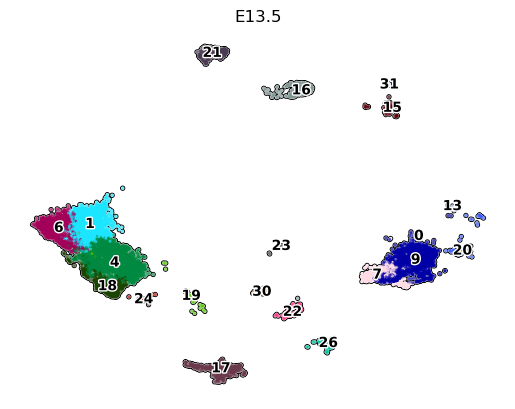

In [21]:
sc.pl.umap(
    adata[adata.obs["bulk.ident"] == "E13.5"],
    color=["leiden_scVI_0.9"],
    frameon=False, title="E13.5", add_outline=True, size=20, legend_loc='on data',legend_fontoutline=2,
)

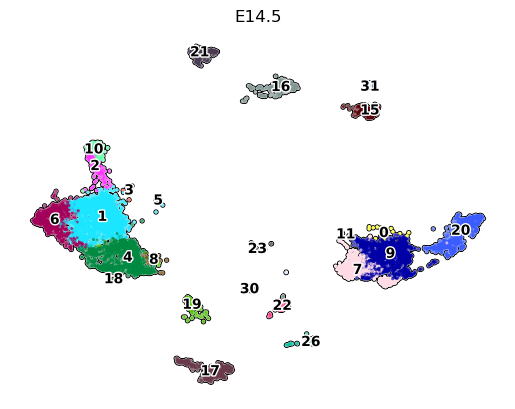

In [22]:
sc.pl.umap(
    adata[adata.obs["bulk.ident"] == "E14.5"],
    color=["leiden_scVI_0.9"],
    frameon=False, title="E14.5", add_outline=True, size=20, legend_loc='on data',legend_fontoutline=2,
)

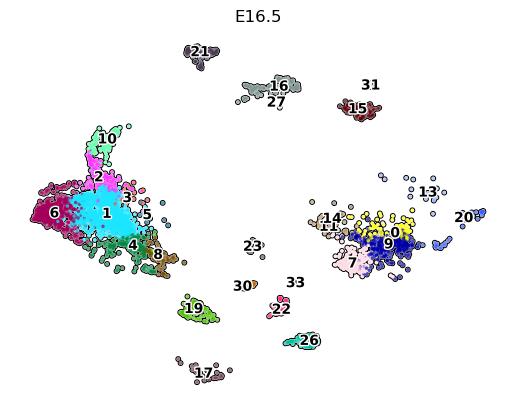

In [23]:
sc.pl.umap(
    adata[adata.obs["bulk.ident"] == "E16.5"],
    color=["leiden_scVI_0.9"],
    frameon=False, title="E16.5", add_outline=True, legend_loc='on data',legend_fontoutline=2,
)

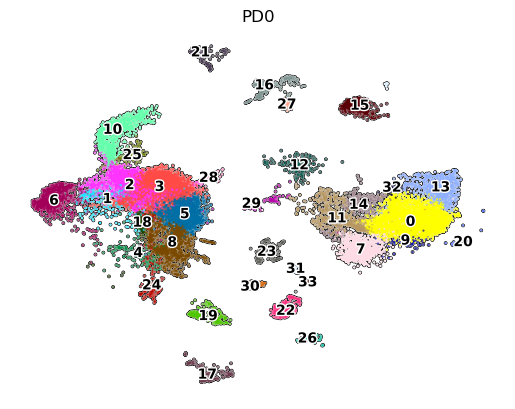

In [24]:
sc.pl.umap(
    adata[adata.obs["bulk.ident"] == "PD0"],
    color=["leiden_scVI_0.9"],
    frameon=False, title="PD0", add_outline=True, size=10, legend_loc='on data',legend_fontoutline=2,
)

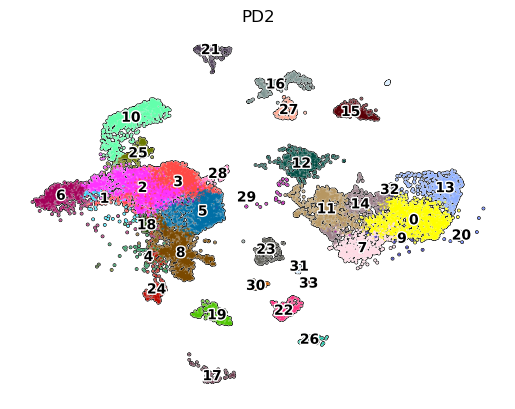

In [25]:
sc.pl.umap(
    adata[adata.obs["bulk.ident"] == "PD2"],
    color=["leiden_scVI_0.9"],
    frameon=False, title="PD2", add_outline=True, size=10, legend_loc='on data',legend_fontoutline=2,
)

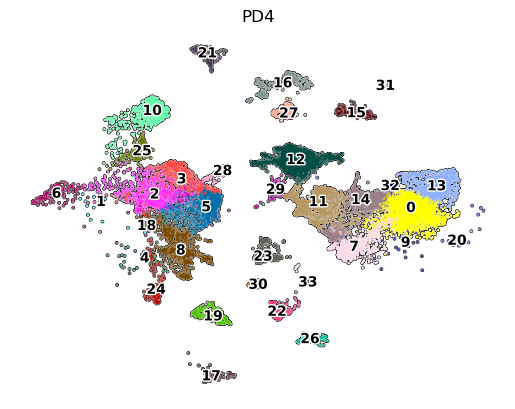

In [26]:
sc.pl.umap(
    adata[adata.obs["bulk.ident"] == "PD4"],
    color=["leiden_scVI_0.9"],
    frameon=False, title="PD4", add_outline=True, size=10, legend_loc='on data',legend_fontoutline=2,
)

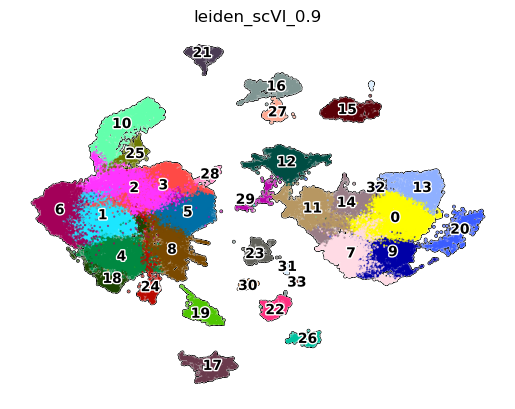

In [27]:
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.9"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, size=10, legend_loc='on data',legend_fontoutline=2,
)

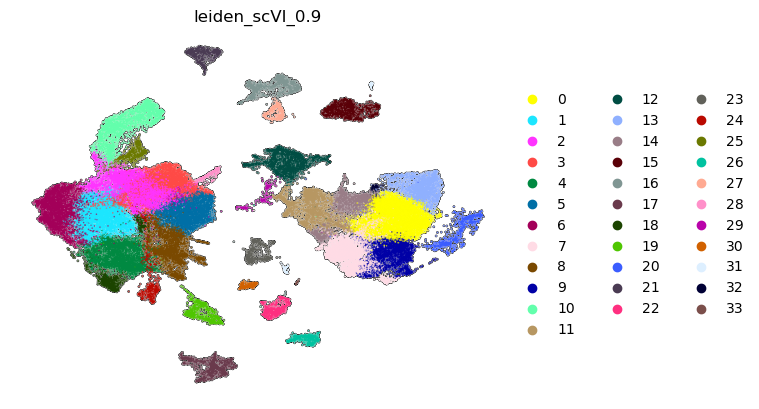

In [28]:
sc.pl.umap(
    adata,
    color=["leiden_scVI_0.9"],
    frameon=False, palette=sc.pl.palettes.default_102, add_outline=True, size=5,legend_fontoutline=2,
)

In [29]:
def cluster_small_multiples(
    adata, clust_key, size=30, frameon=False, legend_loc=None, **kwargs
):
    tmp = adata.copy()

    for i, clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype("category")
        tmp.uns[clust + "_colors"] = ["#d3d3d3", adata.uns[clust_key + "_colors"][i]]

    sc.pl.umap(
        tmp,
        groups=tmp.obs[clust].cat.categories[1:].values,
        color=adata.obs[clust_key].cat.categories.tolist(),
        size=size,
        frameon=frameon,
        legend_loc=legend_loc, add_outline=True,
        **kwargs,
    )

/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories

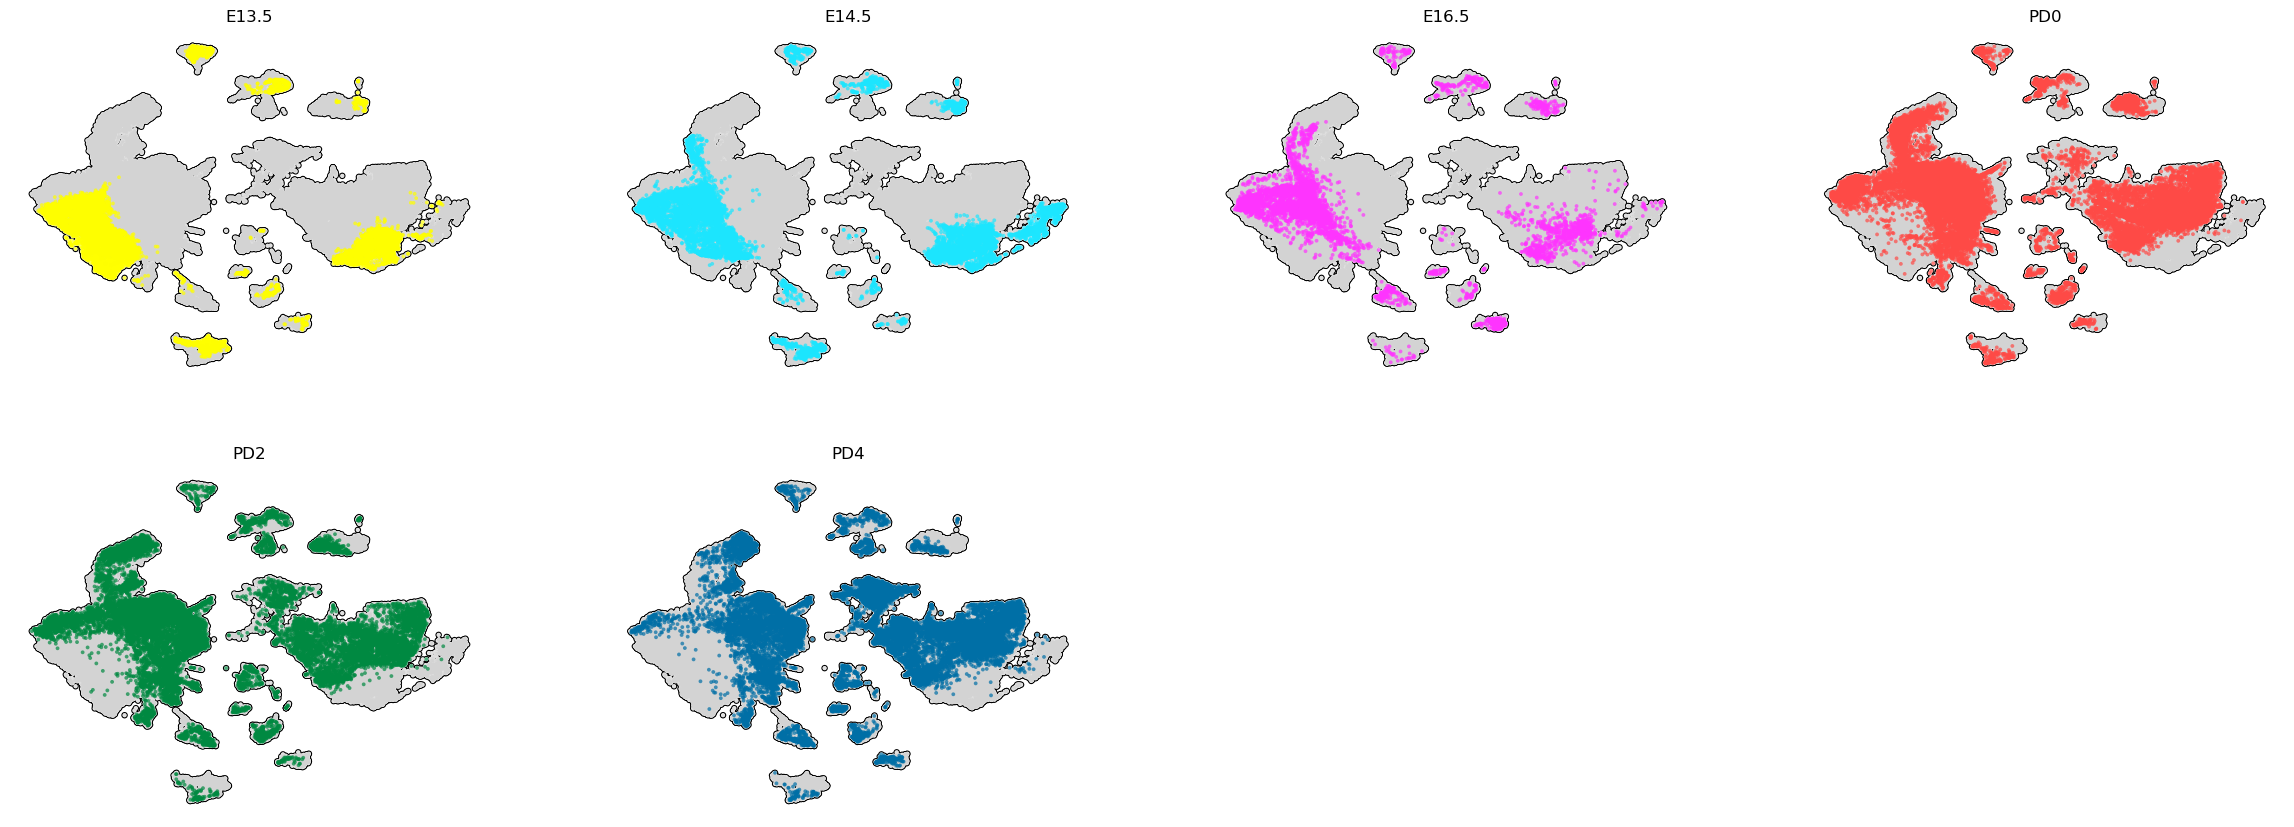

In [30]:
cluster_small_multiples(adata, "bulk.ident")

In [31]:
#DP lineage subcluster

In [32]:
sc.tl.leiden(adata, restrict_to=('leiden_scVI_0.9', ['10']), resolution=0.1, key_added='sub_cluster')

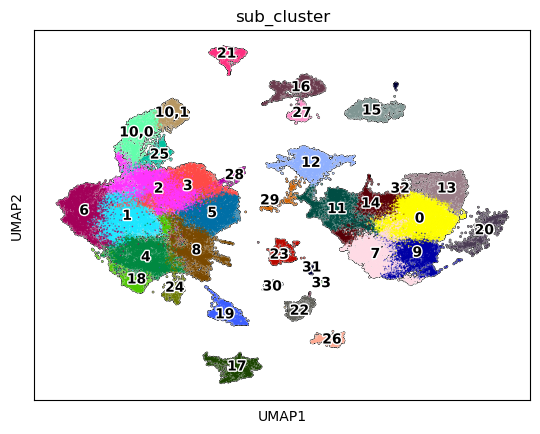

In [33]:
sc.pl.umap(adata, color='sub_cluster', add_outline=True, size=5, legend_loc='on data',legend_fontoutline=2)

In [34]:
new_cluster_names = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34'
    ]
adata.rename_categories('sub_cluster', new_cluster_names)

/mnt/gmi-l1/_90.User_Data/revolvefire/anaconda3/envs/scvi-env-rollback/lib/python3.9/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


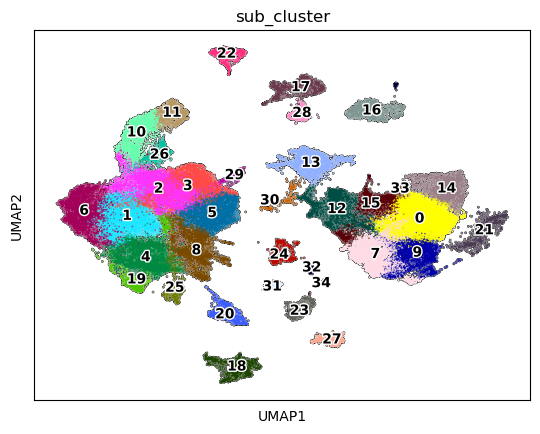

In [35]:
sc.pl.umap(adata, color='sub_cluster', add_outline=True, size=5, legend_loc='on data',legend_fontoutline=2)

In [36]:
#adata.write("221217.adata.e13_pd4.scviintegrated.hvg5500.seed16.min_dist0.4.gene1000.mt7.5.h5ad")

## Dermis subset

In [ ]:
## https://github.com/scverse/scanpy/issues/225
adata_subset = adata[adata.obs['leiden_scVI_0.9'].isin(['1', '2', '3', '4', '5', '6', '8', '10', '18', '24', '25', '28'])]

In [ ]:
sc.pl.umap(
    adata_subset,
    color=["leiden_scVI_0.9"],
    frameon=False, add_outline=True, legend_loc='on data',legend_fontoutline=2
)

In [ ]:
adata = adata_subset

In [ ]:
#adata.write("221212.dermis.adata_lognorm.raw(copy).e13_pd4.concatenated.gene1000.mt7.5.h5ad") ## this is log normalized data with scvi umap and cluster put on

## save scvi outpus

In [ ]:
#save embedding
x_scvi = vae.get_latent_representation()
np.save("/data/_90.User_Data/revolvefire/Jupyter/TWIST2_220616/221205_Final/221217.scvi.hvg5500.e13_pd4.min_dist0.4.outputs/scVI_out.npy", x_scvi)

In [ ]:
## save training stats
model_history = vae.history.copy()
model_history.pop('train_loss_step')
pd.DataFrame.from_dict({k:v[k] for k,v in model_history.items()}).to_csv("/data/_90.User_Data/revolvefire/Jupyter/TWIST2_220616/221205_Final/221217.scvi.hvg5500.e13_pd4.min_dist0.4.outputs/trainhistory.csv")

In [ ]:
x_scvi_umap = adata.obsm['X_umap']

In [ ]:
np.save("/data/_90.User_Data/revolvefire/Jupyter/TWIST2_220616/221205_Final/221217.scvi.hvg5500.e13_pd4.min_dist0.4.outputs/scVI_out.npy.UMAP.npy", x_scvi_umap)

In [ ]:
#save obs data
adata_obs = adata.obs

In [ ]:
adata_obs.to_csv("/data/_90.User_Data/revolvefire/Jupyter/TWIST2_220616/221205_Final/221217.scvi.hvg5500.e13_pd4.min_dist0.4.outputs/scVI_out.npy.clustering.csv")